In [1]:
import sys
import os
scriptpath = "../DeepNeuralNet/"
sys.path.append(os.path.abspath(scriptpath))
import DNN_model as dnn
import math
import pandas as pd
import numpy as np
import re
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
def transformDataForModel(train):            
    train = train.drop('Name', axis = 1).drop('PassengerId', axis = 1).drop('Ticket', axis = 1)
    
    train['Age'] = train['Age'].fillna(0.0)                 
    malesAge = (train[(train['Sex'] == 'male') & (train['Age'] > 0)])['Age']
    femalesAge = (train[(train['Sex'] == 'female') & (train['Age'] > 0)])['Age']
    
    def fillInMedian(x, malesAge, femalesAge):
        if x['Sex'] == 'male' and x['Age'] == 0: 
            return malesAge.median()
        elif x['Sex'] == 'female' and x['Age'] == 0:
            return femalesAge.median()
        else:
            return x['Age']

    train['Age'] = train[['Sex','Age']].apply(lambda x: fillInMedian(x, malesAge, femalesAge), axis = 1)        
    
    # normalize Age
#     train['Age'] = train['Age'] / train['Age'].max()
    
    #normalize fare
#     train['Fare'] = train['Fare'] / train['Fare'].max()
    
    convertSexToNumeric = lambda x: 0 if x == "male" else 1
    train['Sex'] = df['Sex'].apply(convertSexToNumeric)

    train['Embarked'] = train['Embarked'].fillna('')
    enc = LabelEncoder()
    enc.fit(train['Embarked'])
    train['Embarked'] = enc.transform(train['Embarked'])    
    
    train["Cabin"] = train['Cabin'].fillna('')

    def findBaseCabin(x):    
        res = re.search('[a-zA-Z]', x)
        if res is not None:
            return res.group(0)
        else:
            return ''

    train["Cabin"] = train["Cabin"].apply(lambda x: findBaseCabin(x))
    enc.fit(train['Cabin'])
    train['Cabin'] = enc.transform(train['Cabin'])

    train['Family_Size'] = train['SibSp']+train['Parch'] + 1
    train = train.drop('SibSp', axis = 1).drop('Parch', axis = 1).drop('Embarked', axis = 1)
    return train

In [3]:
df = pd.read_csv('kaggle_titanic_data/train.csv')
df_submission = pd.read_csv('kaggle_titanic_data/test.csv')
df = transformDataForModel(df)
m = len(df)
submission = transformDataForModel(df_submission)
submission = submission.T.values 
label = 'Survived'
print df

     Survived  Pclass  Sex   Age      Fare  Cabin  Family_Size
0           0       3    0  22.0    7.2500      0            2
1           1       1    1  38.0   71.2833      3            2
2           1       3    1  26.0    7.9250      0            1
3           1       1    1  35.0   53.1000      3            2
4           0       3    0  35.0    8.0500      0            1
5           0       3    0  29.0    8.4583      0            1
6           0       1    0  54.0   51.8625      5            1
7           0       3    0   2.0   21.0750      0            5
8           1       3    1  27.0   11.1333      0            3
9           1       2    1  14.0   30.0708      0            2
10          1       3    1   4.0   16.7000      7            3
11          1       1    1  58.0   26.5500      3            1
12          0       3    0  20.0    8.0500      0            1
13          0       3    0  39.0   31.2750      0            7
14          0       3    1  14.0    7.8542      0      

Binary classification neural network with hyperparameters:
layer_dims: [3, 1] keep_prob: 0.7 learning_rate: 0.01 num_epochs: 1000 minibatch_size: 1000
Training underway...
Cost after epoch 0: 7.114737
Cost after epoch 500: 0.617034


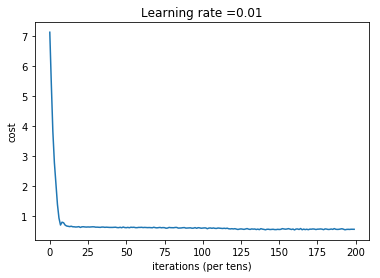

train_accuracy : 0.791667
test_accuracy : 0.794007
precision : 0.847133757962
recall : 0.810975609756
f1score : 0.828660436137
Done training!


50/ 418 survived


In [14]:
bundle = dnn.create_hyperparameter_bundle(layer_dims=[3,1], learning_rate=0.01, num_epochs=1000, keep_prob=0.7, minibatch_size=1000)
model = dnn.train_with_hyperparameter_bundle(df, label, bundle)
param = model[dnn.KEY_PARAMETERS]
prediction = dnn.predict(submission, param, True)
prediction = map(lambda x: int(x), prediction)
ones = sum(prediction)
print str(ones) + "/ " + str(submission.shape[1]) + " survived"

In [5]:
# print_summary = True
# trials = [
#     dnn.create_hyperparameter_bundle(layer_dims=[5, 3, 1], learning_rate=0.0005, num_epochs=5000, keep_prob=1.0, minibatch_size=32)
# #     dnn.create_hyperparameter_bundle(layer_dims=[1], learning_rate=0.05, num_epochs=500, keep_prob=1.0, minibatch_size=258),
# #     dnn.create_hyperparameter_bundle(layer_dims=[1], learning_rate=0.1, num_epochs=500, keep_prob=1.0, minibatch_size=258)
# ]


# best_accuracy = 0
# model = None

# for hyperparams in trials:    
#     res = dnn.kfold(df, label, hyperparams, k = 5, print_summary=print_summary)
#     acc = res[dnn.KEY_AVERAGE_ACCURACY]
#     if acc > best_accuracy:
#         best_accuracy = acc
#         model = res[dnn.KEY_BEST_MODEL]

In [15]:
numSubmission = 10
df_submission['Survived'] = prediction
final = df_submission[['PassengerId','Survived']]
final.to_csv("submissions/submission_" + str(numSubmission) + ".csv", index=False, encoding='utf-8')

In [7]:
# dfsubmis = pd.read_csv('submissions/submission_8.csv')
# print sum(dfsubmis[label])